## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [19]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [20]:
train, test = keras.datasets.cifar10.load_data()

In [21]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [22]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [36]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], before_layer = False):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if before_layer:
                x = BatchNormalization()(input_layer)
                x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            else: 
                x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
                x = BatchNormalization()(x)
        else:
            if before_layer:
                x = BatchNormalization()(x)
                x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [24]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2048, 1024, 512]
MOMENTUM = 0.95

## 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異

In [25]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batch_ in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with batch size = (%d)"% batch_ )
    model = build_mlp(input_shape=x_train.shape[1:] , output_units=10, num_neurons=[512, 256, 128])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_, 
              validation_data=(x_test, y_test), 
              shuffle=True, verbose=0)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "batchsize-%s" % str(batch_)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with batch size = (2048)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)

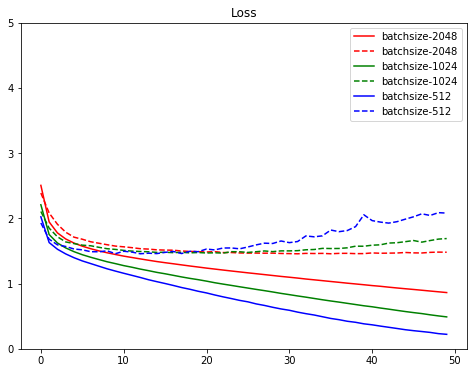

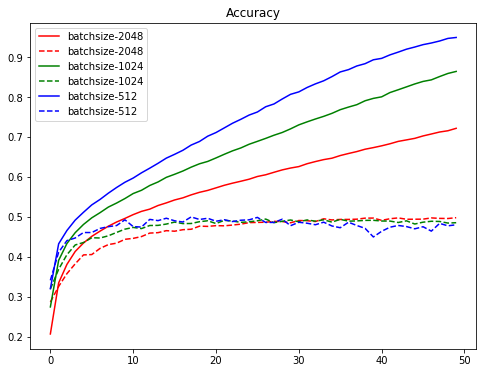

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### batch size : 512容易overfit, 2048有些underfit, 1024較好.

## 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [33]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batch_ in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with batch size = (%d)"% batch_ )
    model = build_mlp(input_shape=x_train.shape[1:] , output_units=10, num_neurons=[512, 256, 128], before_layer = True)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_, 
              validation_data=(x_test, y_test), 
              shuffle=True, verbose=0)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "batchsize-%s" % str(batch_)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with batch size = (2048)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)

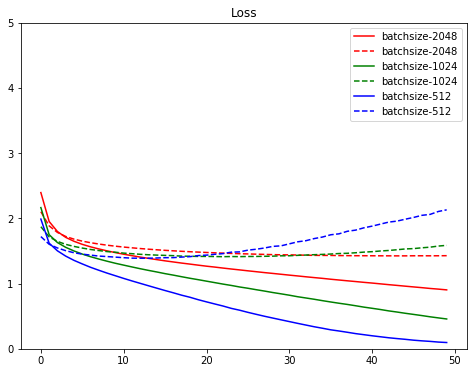

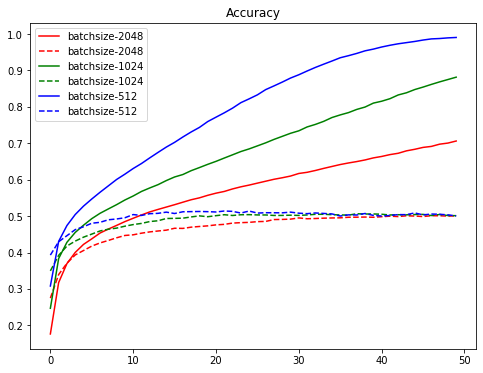

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### 更加Overfit, 故在hidden layer之後較好.

## 請於 BN 放在 Input Layer 後，並比較結果
* 在這裡只在input layer後加入BN層, 其他層BN皆放在layer之後

In [40]:
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model



In [41]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batch_ in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with batch size = (%d)"% batch_ )
    model = build_mlp2(input_shape=x_train.shape[1:] , output_units=10, num_neurons=[512, 256, 128])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_, 
              validation_data=(x_test, y_test), 
              shuffle=True, verbose=0)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "batchsize-%s" % str(batch_)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with batch size = (2048)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)

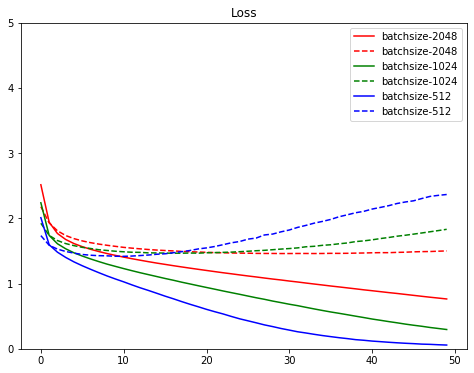

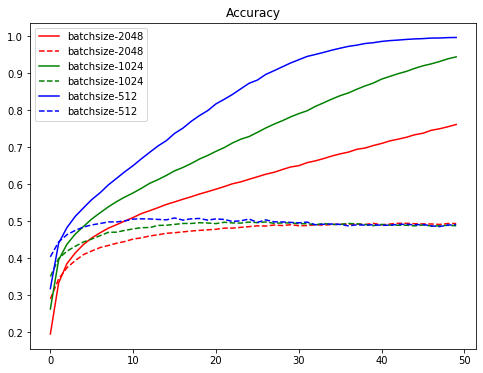

In [42]:
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### BN只是加在input layer後面就會造成overfit, 即使hidden layer是加在activation後面.

### 這表示BN只能加在hidden layer後面.